**Notas para contenedor de docker:**

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_r_kernel_local -p 8888:8888 -d palmoreck/jupyterlab_r_kernel:1.1.0
```

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

```
docker stop jupyterlab_r_kernel_local
```


Documentación de la imagen de docker `palmoreck/jupyterlab_r_kernel:1.1.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/r_kernel).

---

Nota generada a partir de [liga](https://www.dropbox.com/s/6isby5h1e5f2yzs/4.2.Problemas_de_optimizacion_convexa.pdf?dl=0) 

En esta nota revisamos a **regresión logística con y sin regularización**. La **regularización** que utilizamos es la de **[Tikhonov](https://en.wikipedia.org/wiki/Tikhonov_regularization)** también nombrada $\ell_2$ o ***ridge*** y la $\ell_1$ o también conocida como **[*lasso*](https://en.wikipedia.org/wiki/Lasso_(statistics)** (*least absolute shrinkage and selection operator*, Tibshirani, 1996). Se muestra el uso de **métodos de descenso** (ver [4.2.Algoritmos_para_UCO](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.2.Algoritmos_para_UCO.ipynb)) para resolver los problemas de optimización que surgen en los modelos anteriores y **no se tiene por objetivo la interpretabilidad de los resultados**. Se comparan los resultados del paquete  [glm](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/glm), [glmnet stanford](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html), [glmnet cran](https://cran.r-project.org/web/packages/glmnet/index.html) de R con los obtenidos en la implementación hecha por el prof en [algoritmos/R](algoritmos/R), en específico [algoritmos/R/algorithms_for_uco.R](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/algoritmos/R/algorithms_for_uco.R) para problemas tipo UCO (Unconstrained Convex Optimization). 

In [1]:
install.packages(c("latex2exp","glmnet"),lib="/usr/local/lib/R/site-library/",
                repos="https://cran.itam.mx/")

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’




# Problema de clasificación

Sean $\mathcal{C}_0 , \mathcal{C}_1$ dos clases ajenas y $x \in \mathbb{R}^n$. El problema de clasificación consiste en clasificar al vector $x$ en alguna de las dos clases anteriores de modo que se minimice el error de clasificación.


Ejemplos de lo anterior los encontramos en medicina (persona enferma o no dada una serie de mediciones en sangre) o finanzas (persona sujeta a un crédito bancario o no dado un historial crediticio).

En esta nota revisamos a la regresión logística que define un modelo de probabilidad de pertenenecia a una clase.

# Regresión logística: clasificación en $\mathcal{C}_0, \mathcal{C}_1$ 

In [4]:
library(ggplot2)
library(latex2exp)


El modelo por regresión logística tiene por objetivo **modelar las probabilidades de pertenencia a cada una de las clases** $\mathcal{C}_0, \mathcal{C}_1$ dado el vector de atributos $ x \in \mathbb{R}^n$: $p(\mathcal{C}_0|x) , p(\mathcal{C}_1|x)$.

En la regresión logística se utiliza la función **[sigmoide](https://en.wikipedia.org/wiki/Sigmoid_function)** $\sigma:\mathbb{R} \rightarrow \mathbb{R}$:

$$\sigma(t)=\frac{1}{1+\exp(-t)}$$

para modelar ambas probabilidades ya que mapea todo el eje real al intervalo $[0,1]$. Además resulta ser una aproximación continua y diferenciable a la función de **[Heaviside](https://en.wikipedia.org/wiki/Heaviside_step_function)** $H:\mathbb{R} \rightarrow \mathbb{R}$

$$H(t) = 
\begin{cases}
1 & \text{si } t \geq 0,\\
0 & \text{si } t <0\\
\end{cases}
$$



In [11]:
Heaviside <- function(t) 1*(t>0)

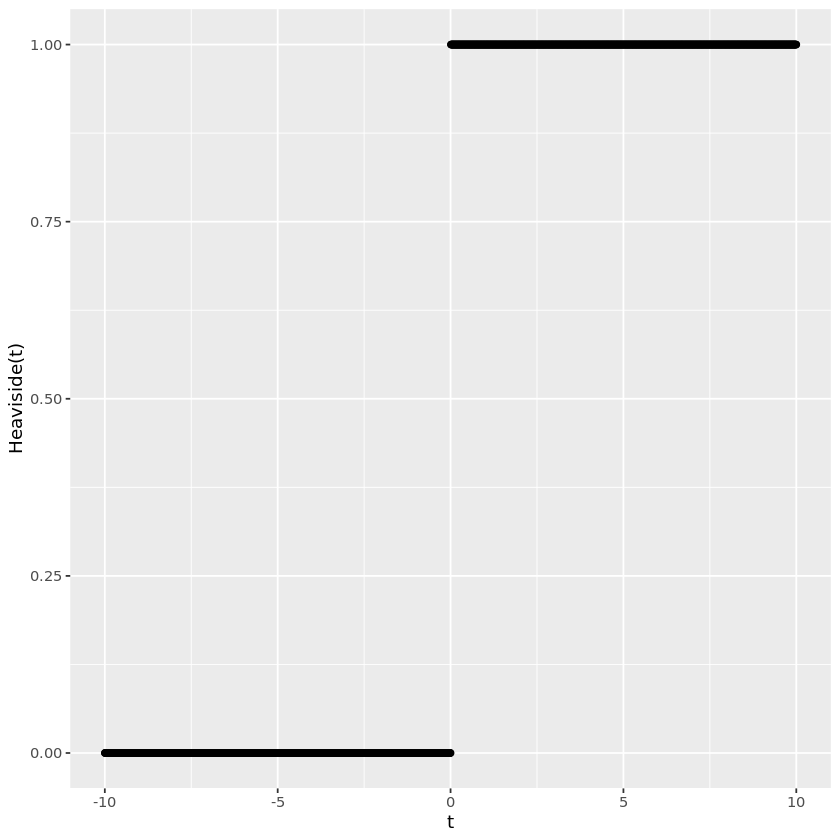

In [12]:
qplot(t, Heaviside(t))

A continuación graficamos a la sigmoide $\sigma(ht)$ para distintos valores de $h \in \{-3, -1, -1/2, 1/2, 1, 3\}$:

In [5]:
sigmoide <- function(t) 1/(1+exp(-t))

In [23]:
t <- seq(from = -10, to = 10, by = .01)
h<-c(-3,-1,-1/2,1/2,1,3)
h_reps <- as.vector(
                    vapply(1:length(h),function(i) rep(h[i], NROW(t)), 
                           numeric(length(t))
                           )
                    )
sigmoide_reps <- as.vector(
                           vapply(1:length(h), function(i) sigmoide(h[i]*t), 
                                  numeric(length(t))      
                                  )
                           )

In [24]:
df <- data.frame(x = rep(t, NROW(h)), 
                 y = sigmoide_reps, 
                 h = as.factor(h_reps)
                 )

In [26]:
gg <- ggplot(df)

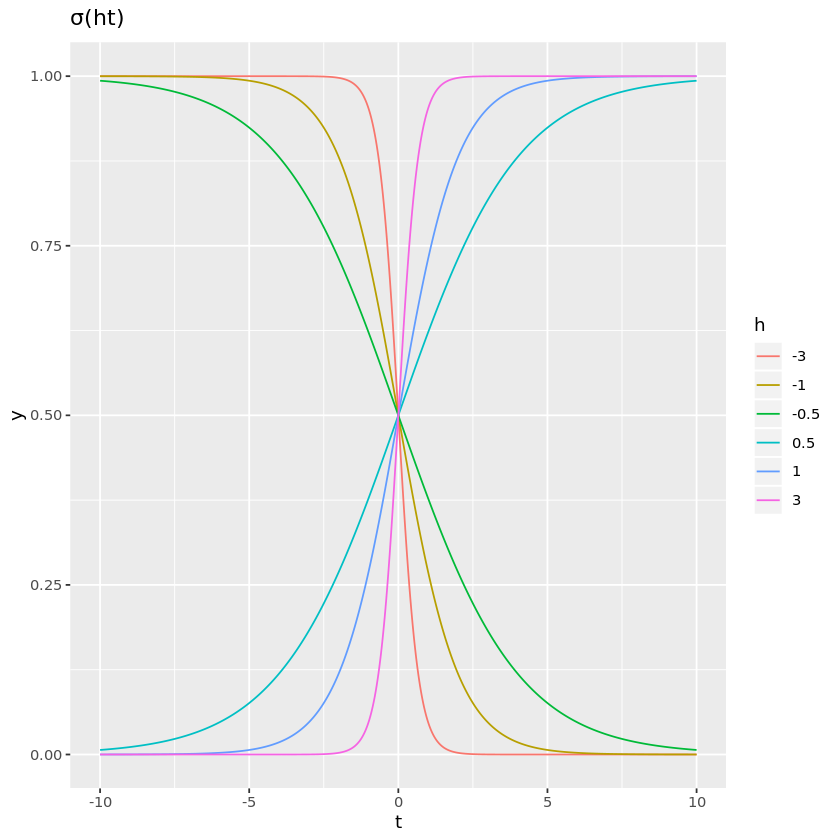

In [27]:
gg + geom_line(aes(x = x, y = y, group = h, color = h)) + 
   xlab('t') + 
   ggtitle(TeX('$\\sigma(ht)$'))

Obsérvese la forma de cada curva al variar $h$ en la función $\sigma(ht)$. Una regla de clasificación podría ser clasificar como perteneciente a $\mathcal{C}_0$ si la probabilidad (modelada por la curva sigmoide) es menor a $0.25$ (**punto de corte**) y perteneciente a $\mathcal{C}_1$ si es mayor o igual a $0.25$. Para diferentes curvas sigmoides presentadas en la gráfica anterior obsérvese que al fijar el punto de corte y tomar un valor de $t$ en el eje horizontal, la pertenencia a alguna de las clases es menos sensible al variar $t$ que en otras curvas.



Así, la función sigmoide permite modelar la probabilidad de pertenencia a la clase $\mathcal{C}_1:$

$$p(\mathcal{C}_1| x)=\sigma(a)$$

para alguna $a \in \mathbb{R}$.

Con el [teorema de Bayes](https://en.wikipedia.org/wiki/Bayes%27_theorem) se obtiene el valor de $a$:

$$
\begin{eqnarray}
p(\mathcal{C}_1|x) &=& \frac{p(x|\mathcal{C}_1)p(\mathcal{C}_1)}{p(x|\mathcal{C}_0)p(\mathcal{C}_0)+p(x|\mathcal{C}_1)p(\mathcal{C}_1)} \nonumber \\
&=& \left ( 1+ \frac{p(x|\mathcal{C}_0)p(\mathcal{C}_0)}{p(x|\mathcal{C}_1)p(\mathcal{C}_1)} \right )^{-1} \nonumber
\end{eqnarray}
$$

Por lo tanto:

$$
\begin{eqnarray}
a(x)&=&\log\left( \frac{p(x|\mathcal{C}_1)p(\mathcal{C}_1)}{p(x|\mathcal{C}_0)p(\mathcal{C}_0)} \right ) \nonumber
\end{eqnarray}
$$

**Comentarios:**

* Entre algunas propiedades que tiene la función $\sigma(\cdot)$ se encuentran:

$$
\begin{eqnarray}
\sigma (-t)&=&1-\sigma (t) \nonumber \\
\frac{d\sigma (t)}{dt}&=&\sigma (t)(1-\sigma (t)) \nonumber
\end{eqnarray}
$$


* En Estadística a la función:

$$a=\log\left(\frac{\sigma}{1-\sigma}\right)$$

se le conoce como [**logit**](https://en.wikipedia.org/wiki/Logit) y modela el log momio:




$$\log \left(\frac{p(\mathcal{C}_1|x)}{p(\mathcal{C}_0|x)}\right)=\log \left(\frac{p(\mathcal{C}_1|x)}{1-p(\mathcal{C}_1|x)}\right)$$

que tiene una interpretación directa en términos de las probabilidades de pertenencia a cada clase $\mathcal{C}_0,\mathcal{C}_1$.

## ¿Modelo en regresión logística?

### Regresión logística con dos clases

De forma similar como en el modelo por mínimos cuadrados lineales (ver [4.3.Minimos_cuadrados_R](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.3.Minimos_cuadrados_R.ipynb)) se modeló a la variable respuesta $y$ con una función lineal en sus parámetros, en el modelo en regresión logística **con dos clases** se propone una función lineal en un vector de parámetros $(\beta_0,\beta) \in \mathbb{R}^{n+1}$ dada por el logit:

$$
\beta^T x+\beta_0=a(x|\beta_0,\beta)=\log \left(\frac{p(\mathcal{C}_1|x)}{p(\mathcal{C}_0|x)}\right).
$$


Obsérvese que si $y$ es considerada como variable respuesta que está en función de $x \in \mathbb{R}^{n+1}$ dado el vector $(\beta_0, \beta)$ se tiene:


$$p(\mathcal{C}_1 | x ) = y(x | \beta_0, \beta) = \frac{1}{1+ e^{-(\beta_0, \beta)^T x}}$$

que se lee "la probabilidad de pertenencia a la clase $\mathcal{C}_0$ dado el vector de atributos $x$ es igual a $y$.


**Comentarios:** 

* El modelo anterior con $2$ parámetros $\beta_0, \beta_1$ se ve como:

$$p(\mathcal{C}_1 | x ) = y(x | \beta_0, \beta) = \frac{1}{1+ e^{-(\beta_0 + \beta_1x)}}$$


con $x \in \mathbb{R}$.



* El modelo anterior puede extenderse utilizando $n+1$ funciones conocidas $\phi_j:\mathbb{R} \rightarrow \mathbb{R}$, $\phi_j(x)$ $j=0,\dots, n$ por lo que si $\phi(x)=(\phi_0(x),\phi_1(x),\dots,\phi_n(x))^T$ y $\beta_0 \in \mathbb{R}$, $\beta \in \mathbb{R}^n$, entonces se tiene el modelo por regresión logística:

$$
p(\mathcal{C}_0|\phi(x))=y(x|\beta_0, \beta)= \frac{1}{1+ e^{-(\beta_0, \beta)^T \phi(x)}}
$$

* La notación $y(x | \beta_0, \beta)$ se utiliza para denotar que $(\beta_0, \beta)$ es un vector de parámetros a estimar, en específico $\beta_0, \beta_1, \dots, \beta_n$, esto es: $n+1$ parámetros a estimar.

* La variable de optimización es $(\beta_0, \beta)$.

Se codifican a las clases $\mathcal{C}_0,\mathcal{C}_1$ con los valores de $\{0,1\}$ y típicamente se tienen que realizar $y_0=y_0(x_0|(\beta_0, \beta),y_1=y_1(x_1|(\beta_0, \beta),\dots,y_m=y_m(x_n|(\beta_0, \beta)$ clasificaciones etiquetadas con $\hat{y} \in \mathbb{R}^{n+1}$, $\hat{y}=(\hat{y}_i)_{i=0}^{n}$, $\hat{y}_i \in \{0,1\}$ con $m+1 \gg {n+1}$ para un número ${n+1}$ fijo de funciones $\phi_j (\cdot)$ 

Los $n+1$ parámetros se ajustan **maximizando** la [función de verosimilitud](https://en.wikipedia.org/wiki/Likelihood_function):

$$
\mathcal{L}(\beta_0, \beta|x)=\displaystyle \prod_{i=0}^n y_i^{\hat{y}_i}(1-y_i)^{1-\hat{y}_i}
$$

donde: $\hat{y}_i \sim \text{Bernoulli}(y_i)$ y por tanto $\hat{y}_i \in \{0,1\}$: $\hat{y}_i = 1$ con probabilidad $y_i$ y $\hat{y}_i = 0$ con probabilidad $1-y_i$. Entonces se tiene el problema:



$$\displaystyle \max_{(\beta_0, \beta) \in \mathbb{R}^{n+1}} \mathcal{L}(\beta_0, \beta|x)=\displaystyle \prod_{i=0}^n y_i^{\hat{y}_i}(1-y_i)^{1-\hat{y}_i}$$

Lo anterior es equivalente a maximizar la log-verosimilitud:

$$
\begin{eqnarray}
\ell((\beta_0, \beta) |x)&=&\log(\mathcal{L}(\beta_0, \beta| x)) \nonumber\\
&=&\displaystyle \sum_{i=1}^m \hat{y}_i\log(y_i)+(1-\hat{y}_i)\log(1-y_i) \nonumber\\
&=&\displaystyle \sum_{i=1}^m\hat{y}_i (\beta_0, \beta)^T \phi(x_i)-\log(1+\exp((\beta_0, \beta)^T\phi(x_i)) \nonumber
\end{eqnarray}
$$

In [1]:
library(datasets)
library(dplyr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
data(iris)
summary(iris)
nrow(iris)
ncol(iris)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

[1] 150

[1] 5

In [3]:
iris_subset <- filter(iris, Species %in% c("virginica", "versicolor"))


In [4]:
head(iris_subset)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,7.0,3.2,4.7,1.4,versicolor
2,6.4,3.2,4.5,1.5,versicolor
3,6.9,3.1,4.9,1.5,versicolor
4,5.5,2.3,4.0,1.3,versicolor
5,6.5,2.8,4.6,1.5,versicolor
6,5.7,2.8,4.5,1.3,versicolor


In [5]:
nrow(iris_subset)


[1] 100

In [6]:
cor(as.matrix(iris_subset[,-ncol(iris_subset)]))

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,1.0000000,0.5538548,0.8284787,0.5937094
Sepal.Width,0.5538548,1.0000000,0.5198023,0.5662025
Petal.Length,0.8284787,0.5198023,1.0000000,0.8233476
Petal.Width,0.5937094,0.5662025,0.8233476,1.0000000


In [7]:
A<-iris_subset[,-c(3,ncol(iris_subset))]

In [8]:
y_hat <- iris_subset[,ncol(iris_subset)]

In [9]:
head(A)

,Sepal.Length,Sepal.Width,Petal.Width
,<dbl>,<dbl>,<dbl>
1,7.0,3.2,1.4
2,6.4,3.2,1.5
3,6.9,3.1,1.5
4,5.5,2.3,1.3
5,6.5,2.8,1.5
6,5.7,2.8,1.3


In [10]:
head(y_hat)

[1] versicolor versicolor versicolor versicolor versicolor versicolor
Levels: setosa versicolor virginica

In [11]:
glm.out <- glm(Species ~ Sepal.Length + Sepal.Width  + Petal.Width,
               data = iris_subset,family = binomial)


In [12]:
summary(glm.out)


Call:
glm(formula = Species ~ Sepal.Length + Sepal.Width + Petal.Width, 
    family = binomial, data = iris_subset)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.62754  -0.12171  -0.00435   0.06825   2.32596  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -20.287      8.055  -2.519   0.0118 *  
Sepal.Length    1.295      1.089   1.189   0.2344    
Sepal.Width    -4.823      2.097  -2.300   0.0214 *  
Petal.Width    15.923      3.981   4.000 6.33e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 138.629  on 99  degrees of freedom
Residual deviance:  25.902  on 96  degrees of freedom
AIC: 33.902

Number of Fisher Scoring iterations: 8


In [13]:
glm.out$coefficients

(Intercept) Sepal.Length  Sepal.Width  Petal.Width 
  -20.287329     1.295129    -4.823274    15.922660

# Descenso en gradiente

$$2 \displaystyle \sum_{i=1}^m log(1+exp(\beta^Tx_i))-\hat{y}_i\beta^Tx_i$$

donde: $\hat{y}_i \in \{0,1\}$, $x_i$ $i$-ésimo renglón de matriz A.

In [14]:
head(A)

,Sepal.Length,Sepal.Width,Petal.Width
,<dbl>,<dbl>,<dbl>
1,7.0,3.2,1.4
2,6.4,3.2,1.5
3,6.9,3.1,1.5
4,5.5,2.3,1.3
5,6.5,2.8,1.5
6,5.7,2.8,1.3


In [15]:
A<-cbind(rep(1,nrow(A)),A)

In [16]:
head(A)

,"rep(1, nrow(A))",Sepal.Length,Sepal.Width,Petal.Width
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,7.0,3.2,1.4
2,1,6.4,3.2,1.5
3,1,6.9,3.1,1.5
4,1,5.5,2.3,1.3
5,1,6.5,2.8,1.5
6,1,5.7,2.8,1.3


In [17]:
y_hat <- iris_subset[,ncol(iris_subset)]

In [18]:
head(y_hat)

[1] versicolor versicolor versicolor versicolor versicolor versicolor
Levels: setosa versicolor virginica

In [19]:
tail(y_hat)

[1] virginica virginica virginica virginica virginica virginica
Levels: setosa versicolor virginica

In [20]:
#y_hat <- as.numeric(y_hat)-2
#or 
y_hat <- as.numeric(y_hat)-3
#then: 
y_hat[y_hat==-1] <- -1*y_hat[y_hat==-1]

In [21]:
head(y_hat)

[1] 1 1 1 1 1 1

In [22]:
tail(y_hat)

[1] 0 0 0 0 0 0

In [23]:
#load numerical differentiation
#load utils
#load algorithms for unconstrained convex optimization
#load line search
dir_R="algoritmos/R"
source(paste(dir_R,"/numerical_differentiation.R", 
             sep=""))
source(paste(dir_R,"/utils.R", 
             sep=""))
source(paste(dir_R,"/algorithms_for_uco.R", 
             sep=""))
source(paste(dir_R,"/line_search.R",
             sep=""))

$$2 \displaystyle \sum_{i=1}^m log(1+exp(\beta^Tx_i))-\hat{y}_i\beta^Tx_i$$

donde: $\hat{y}_i \in \{0,1\}$, $x_i$ $i$-ésimo renglón de matriz A.

In [24]:
beta_0 <- c(0,0,0,0)

In [25]:
A<-as.matrix(A)

In [26]:
head(A)

"rep(1, nrow(A))",Sepal.Length,Sepal.Width,Petal.Width
1,7.0,3.2,1.4
1,6.4,3.2,1.5
1,6.9,3.1,1.5
1,5.5,2.3,1.3
1,6.5,2.8,1.5
1,5.7,2.8,1.3


In [27]:
cor(A[,-1])

,Sepal.Length,Sepal.Width,Petal.Width
Sepal.Length,1.0000000,0.5538548,0.5937094
Sepal.Width,0.5538548,1.0000000,0.5662025
Petal.Width,0.5937094,0.5662025,1.0000000


In [28]:
fo <- function(beta){
    mat_vec <- A%*%beta
    2*sum(log(1+exp(mat_vec))-y_hat*mat_vec)
    }

### Método de descenso en gradiente

Usando $\beta_0=(1,1,1,1)^T$:

In [29]:
beta_0 <- c(1,1,1,1)

In [30]:
beta_ast <- glm.out$coefficients


In [31]:
beta_ast

(Intercept) Sepal.Length  Sepal.Width  Petal.Width 
  -20.287329     1.295129    -4.823274    15.922660

In [32]:
p_ast <- fo(beta_ast)

In [33]:
p_ast

[1] 1126.536

In [34]:
tol <- 1e-8
tol_backtracking <- 1e-14
maxiter <- 30
p_ast <- fo(beta_ast)


In [35]:
l<-gradient_descent(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I    Normagf   Error x_ast   Error p_ast   line search
1    7.57e+02   1.01e+00      1.32e+02      ---
2    6.76e+02   1.02e+00      2.36e+02      0.00390625
3    7.45e+01   1.02e+00      9.80e+02      0.001953125
4    3.35e+01   1.02e+00      9.81e+02      0.00048828125
5    7.26e+01   1.02e+00      9.82e+02      0.001953125
6    3.30e+01   1.02e+00      9.83e+02      0.00048828125
7    7.13e+01   1.02e+00      9.84e+02      0.001953125
8    3.26e+01   1.02e+00      9.85e+02      0.00048828125
9    7.04e+01   1.02e+00      9.86e+02      0.001953125
10    3.22e+01   1.02e+00      9.87e+02      0.00048828125
11    6.99e+01   1.02e+00      9.88e+02      0.001953125
12    3.18e+01   1.03e+00      9.89e+02      0.00048828125
13    6.95e+01   1.03e+00      9.89e+02      0.001953125
14    3.15e+01   1.03e+00      9.91e+02      0.00048828125
15    6.93e+01   1.03e+00      9.91e+02      0.001953125
16    3.12e+01   1.03e+00      9.92e+02      0.00048828125
17    6.91e+01   1.03e+00      9.93e+

In [36]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


In [37]:
print(beta)

[1]  0.9645237 -0.3067851  0.4984840 -0.3660336


In [38]:
print(beta_ast)

 (Intercept) Sepal.Length  Sepal.Width  Petal.Width 
  -20.287329     1.295129    -4.823274    15.922660 


In [39]:
compute_error(x_approx = beta,x_obj = beta_ast)

[1] 1.04104

In [40]:
l<-coordinate_descent(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I    Normagf   Error x_ast   Error p_ast   line search
1    7.57e+02   1.01e+00      1.32e+02      ---
2    6.52e+02   1.02e+00      6.99e+02      0.00390625
3    6.60e+02   1.02e+00      8.11e+02      0.001953125
4    2.20e+02   1.02e+00      9.54e+02      0.0009765625
5    4.24e+01   1.02e+00      9.65e+02      0.00048828125
6    3.25e+01   1.02e+00      9.65e+02      0.00048828125
7    1.39e+02   1.02e+00      9.69e+02      0.0078125
8    3.22e+01   1.02e+00      9.73e+02      0.00048828125
9    1.34e+02   1.03e+00      9.76e+02      0.0078125
10    3.07e+01   1.03e+00      9.80e+02      0.00048828125
11    1.30e+02   1.03e+00      9.82e+02      0.0078125
12    2.93e+01   1.03e+00      9.86e+02      0.00048828125
13    1.26e+02   1.04e+00      9.88e+02      0.0078125
14    2.80e+01   1.04e+00      9.92e+02      0.00048828125
15    1.21e+02   1.04e+00      9.94e+02      0.0078125
16    2.68e+01   1.04e+00      9.97e+02      0.00048828125
17    1.16e+02   1.04e+00      9.99e+02      0

In [41]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


In [42]:
print(beta)

[1]  1.0000000 -0.3073872  1.0000000 -1.2274378


In [43]:
print(beta_ast)

 (Intercept) Sepal.Length  Sepal.Width  Petal.Width 
  -20.287329     1.295129    -4.823274    15.922660 


In [44]:
tol <- 1e-8
tol_backtracking <- 1e-14
maxiter <- 30
p_ast <- fo(beta_ast)


In [45]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I    Normgf   Newton Decrement   Error x_ast   Error p_ast   line search    condHf
1    7.57e+02   1.33e+06           1.01e+00      1.32e+02      ---         4.05e+00
2    1.93e+02   2.84e+02           1.01e+00      9.41e+02      9.77e-04    7.05e+03
3    9.70e+01   2.56e+01           1.26e+00      1.08e+03      1.00e+00    5.79e+03
4    3.08e+01   1.03e+01           1.46e+00      1.09e+03      1.00e+00    7.18e+03
5    9.25e+00   2.78e+00           1.68e+00      1.10e+03      1.00e+00    7.50e+03
6    1.52e+00   3.78e-01           1.84e+00      1.10e+03      1.00e+00    6.27e+03
7    7.86e-02   1.84e-01           1.92e+00      1.10e+03      1.00e+00    1.69e+04
8    1.28e-01   1.01e-02           2.02e+00      1.10e+03      1.00e+00    7.21e+03
9    9.80e-03   1.25e-02           2.01e+00      1.10e+03      1.00e+00    6.71e+04
10    4.83e-03   7.50e-05           2.00e+00      1.10e+03      2.50e-01    8.13e+03
11    8.75e-04   -1.25e-04           2.00e+00      1.10e+03      1.00e+00   

In [46]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


In [47]:
print(beta)

[1]  20.262418  -1.292617   4.822189 -15.915167


In [48]:
print(beta_ast)

 (Intercept) Sepal.Length  Sepal.Width  Petal.Width 
  -20.287329     1.295129    -4.823274    15.922660 


**Comparación con paquete glmnet**

In [49]:
#install.packages(c("latex2exp","glmnet"),lib="/usr/local/lib/R/site-library/",
#                repos="https://cran.itam.mx/")

In [50]:
library(glmnet)

Loading required package: Matrix

Loaded glmnet 3.0-2




In [51]:
fit<-glmnet(A[,-1],y_hat,family="binomial",alpha=0,lambda=0,standardize=F,nlambda=1, thresh=1e-8)


In [52]:
beta_ast <- as.matrix(fit$beta)

In [53]:
print(beta_ast)

                     s0
Sepal.Length  -1.295005
Sepal.Width    4.823018
Petal.Width  -15.922371


In [54]:
compute_error(x_approx = beta[-1], x_obj = beta_ast)

[1] 0.0004575515

In [55]:
head(A)

"rep(1, nrow(A))",Sepal.Length,Sepal.Width,Petal.Width
1,7.0,3.2,1.4
1,6.4,3.2,1.5
1,6.9,3.1,1.5
1,5.5,2.3,1.3
1,6.5,2.8,1.5
1,5.7,2.8,1.3


# Penalización ridge con intercepto

In [56]:
reg<-0.5

In [57]:
fit<-glmnet(A,y_hat,family="binomial",alpha=0,lambda=reg,standardize=F,nlambda=1, thresh=1e-8)


In [58]:
beta_ast<-as.matrix(fit$beta)

In [59]:
print(beta_ast)

                         s0
rep(1, nrow(A))  0.00000000
Sepal.Length    -0.24479206
Sepal.Width     -0.07182931
Petal.Width     -0.30070071


In [60]:
#svd of A
singular_value_decomposition <- svd(A)
s <- singular_value_decomposition$d
u <- singular_value_decomposition$u
tv <- t(singular_value_decomposition$v)

cte_svd <- s/(s^2+reg)*(t(u)%*%y_hat)

In [61]:
beta_ridge <- solve(tv,cte_svd)

In [62]:
beta_ridge

1.073147786
-0.007613912
0.452737088
-1.092539453


**con Newton**

In [63]:
head(A)

"rep(1, nrow(A))",Sepal.Length,Sepal.Width,Petal.Width
1,7.0,3.2,1.4
1,6.4,3.2,1.5
1,6.9,3.1,1.5
1,5.5,2.3,1.3
1,6.5,2.8,1.5
1,5.7,2.8,1.3


In [64]:
mpoints<-nrow(A)

In [65]:
fo <-function(beta){
    mat_vec <- A %*% beta
    1/mpoints*(sum(log(1 + exp(mat_vec)) - y_hat * mat_vec)) + reg/2*sum(beta[2:length(beta)]*beta[2:length(beta)])
    }

In [66]:
beta_0 <- c(0,0,0,0)

In [67]:
p_ast <- fo(beta_ast)

In [68]:
p_ast

[1] 1.168373

In [69]:
tol <- 1e-12
tol_backtracking <- 1e-14
maxiter <- 30
p_ast <- fo(beta_ast)


In [70]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I    Normgf   Newton Decrement   Error x_ast   Error p_ast   line search    condHf
1    2.45e-01   9.60e-02           1.00e+00      4.75e-01      ---         1.14e+03
2    1.43e-03   3.95e-07           5.68e+00      5.23e-01      1.00e+00    1.13e+03
3    6.14e-07   1.79e-12           5.69e+00      5.23e-01      1.00e+00    1.14e+03
Error of x with respect to x_ast: 5.69e+00
Approximate solution:[1]  2.24298485 -0.24479077 -0.07182857 -0.30070082


In [71]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


In [72]:
print(beta)

[1]  2.24298485 -0.24479077 -0.07182857 -0.30070082


In [73]:
print(beta_ast)

                         s0
rep(1, nrow(A))  0.00000000
Sepal.Length    -0.24479206
Sepal.Width     -0.07182931
Petal.Width     -0.30070071


# Penalización Ridge sin intercepto

In [74]:
A<-A[,-1]

In [75]:
head(A)

Sepal.Length,Sepal.Width,Petal.Width
7.0,3.2,1.4
6.4,3.2,1.5
6.9,3.1,1.5
5.5,2.3,1.3
6.5,2.8,1.5
5.7,2.8,1.3


In [76]:
fit<-glmnet(A,y_hat,family="binomial",alpha=0,lambda=reg,standardize=F,nlambda=1, intercept=F, thresh=1e-8)


In [77]:
beta_ast <- as.matrix(fit$beta)

In [78]:
print(beta_ast)

                      s0
Sepal.Length  0.02157718
Sepal.Width   0.05710003
Petal.Width  -0.24262286


In [79]:
#svd of A
singular_value_decomposition <- svd(A)
s <- singular_value_decomposition$d
u <- singular_value_decomposition$u
tv <- t(singular_value_decomposition$v)

cte_svd <- s/(s^2+reg)*(t(u)%*%y_hat)

In [80]:
beta_ridge <- solve(tv,cte_svd)

In [81]:
beta_ridge

0.1112952
0.6207321
-1.1897780


## Método de Newton

In [82]:
beta_0 <- c(0,0,0)

In [83]:
p_ast <- fo(beta_ast)

In [84]:
p_ast

[1] 0.6750204

In [85]:
tol <- 1e-12
tol_backtracking <- 1e-14
maxiter <- 30
p_ast <- fo(beta_ast)


In [86]:
mpoints<-nrow(A)

In [87]:
fo <-function(beta){
    mat_vec <- A %*% beta
    1/mpoints*(sum(log(1 + exp(mat_vec)) - y_hat * mat_vec)) + reg/2*sum(beta*beta)
    }

In [88]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I    Normgf   Newton Decrement   Error x_ast   Error p_ast   line search    condHf
1    2.45e-01   3.60e-02           1.00e+00      1.81e-02      ---         2.55e+01
2    5.61e-04   2.53e-08           2.79e-04      1.16e-04      1.00e+00    2.54e+01
3    4.15e-08   1.97e-15           5.27e-05      1.16e-04      1.00e+00    2.54e+01
Error of x with respect to x_ast: 5.27e-05
Approximate solution:[1]  0.02157031  0.05711028 -0.24261826


In [89]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


In [90]:
print(beta)

[1]  0.02157031  0.05711028 -0.24261826


In [91]:
print(beta_ast)

                      s0
Sepal.Length  0.02157718
Sepal.Width   0.05710003
Petal.Width  -0.24262286


In [92]:
compute_error(x_approx = beta, x_obj = beta_ast)

[1] 5.26635e-05

## Penalización Lasso sin intercepto

In [93]:
fit<-glmnet(A,y_hat,family="binomial",alpha=1,lambda=reg,standardize=F,nlambda=1, intercept=F, thresh=1e-8)


In [94]:
beta_ast <- as.matrix(fit$beta)

In [95]:
print(beta_ast)

             s0
Sepal.Length  0
Sepal.Width   0
Petal.Width   0


In [97]:
quita_signo<-function(beta){
    beta<-sign(beta)*beta
    ind <- beta < .Machine$double.xmin & beta > -.Machine$double.xmin 
    beta[ind] <- .Machine$double.xmin 
    beta
    }

In [98]:
fo <-function(beta){
    mat_vec <- A %*% beta
    1/mpoints*(sum(log(1 + exp(mat_vec)) - y_hat * mat_vec)) + reg*sum(quita_signo(beta))
    }

In [108]:
#l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

In [109]:
#beta <- l[[1]]
#total_of_iterations <- l[[2]]
#Err_plot <- l[[3]]
#beta_plot <- l[[4]]
#

In [110]:
#print(beta)

In [111]:
#print(beta_ast)

In [112]:
#compute_error(x_approx = beta, x_obj = beta_ast)

### Cambiando parámetro de regularización

In [99]:
reg<-.01

In [100]:
head(A)

Sepal.Length,Sepal.Width,Petal.Width
7.0,3.2,1.4
6.4,3.2,1.5
6.9,3.1,1.5
5.5,2.3,1.3
6.5,2.8,1.5
5.7,2.8,1.3


In [101]:
fit<-glmnet(A,y_hat,family="binomial",alpha=1,lambda=reg,standardize=F,nlambda=1, intercept=F, thresh=1e-8)


In [102]:
beta_ast <- as.matrix(fit$beta)

In [103]:
print(beta_ast)

                     s0
Sepal.Length  0.6246049
Sepal.Width   3.0968033
Petal.Width  -7.8624767


In [104]:
beta_0<-c(1,1,1)

In [105]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I    Normgf   Newton Decrement   Error x_ast   Error p_ast   line search    condHf
1    3.77e+00   6.18e+03           1.08e+00      5.15e+00      ---         5.41e+00
2    4.53e-01   2.39e-01           7.19e-01      1.73e-01      9.77e-04    7.90e+02
3    1.81e-01   4.24e-02           3.57e-01      3.08e-01      1.00e+00    8.36e+02
4    5.06e-02   4.76e-03           1.19e-01      3.33e-01      1.00e+00    1.09e+03
5    6.55e-03   7.16e-05           1.41e-02      3.36e-01      1.00e+00    1.21e+03
6    1.15e-04   7.11e-08           8.06e-04      3.36e-01      1.00e+00    1.24e+03
7    1.60e-07   6.13e-12           9.60e-04      3.36e-01      1.00e+00    1.27e+03
8    1.92e-08   1.35e-14           9.63e-04      3.36e-01      1.00e+00    1.26e+03
Error of x with respect to x_ast: 9.63e-04
Approximate solution:[1]  0.6222248  3.1038730 -7.8657876


In [106]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


In [107]:
print(beta)

[1]  0.6222248  3.1038730 -7.8657876


In [108]:
print(beta_ast)

                     s0
Sepal.Length  0.6246049
Sepal.Width   3.0968033
Petal.Width  -7.8624767


In [110]:
compute_error(x_approx = beta, x_obj = beta_ast)

[1] 0.000963169

**Siguientes ejemplos no funcionan:**

### Lasso con intercepto

In [111]:
A<-iris_subset[,-c(3,ncol(iris_subset))]

In [112]:
head(A)

,Sepal.Length,Sepal.Width,Petal.Width
,<dbl>,<dbl>,<dbl>
1,7.0,3.2,1.4
2,6.4,3.2,1.5
3,6.9,3.1,1.5
4,5.5,2.3,1.3
5,6.5,2.8,1.5
6,5.7,2.8,1.3


In [113]:
A<-cbind(rep(1,nrow(A)),A)

In [114]:
A<-as.matrix(A)

In [115]:
head(A)

"rep(1, nrow(A))",Sepal.Length,Sepal.Width,Petal.Width
1,7.0,3.2,1.4
1,6.4,3.2,1.5
1,6.9,3.1,1.5
1,5.5,2.3,1.3
1,6.5,2.8,1.5
1,5.7,2.8,1.3


In [116]:
fit<-glmnet(A,y_hat,family="binomial",alpha=1,lambda=reg,standardize=F,nlambda=1, thresh=1e-8)


In [117]:
beta_ast <- as.matrix(fit$beta)

In [118]:
print(beta_ast)

                        s0
rep(1, nrow(A))  0.0000000
Sepal.Length    -0.1508808
Sepal.Width      0.7099626
Petal.Width     -8.5108838


In [119]:
fo <-function(beta){
    mat_vec <- A %*% beta
    1/mpoints*(sum(log(1 + exp(mat_vec)) - y_hat * mat_vec)) + reg*sum(quita_signo(beta[2:length(beta)]))
    }

In [120]:
beta_0<-c(1,1,1,1)

In [121]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I    Normgf   Newton Decrement   Error x_ast   Error p_ast   line search    condHf
1    3.80e+00   2.46e+03           1.13e+00      5.65e+00      ---         7.84e+00
2    3.35e+00   7.48e+01           8.21e-01      1.91e+00      3.91e-03    1.22e+03
3    7.48e-01   -2.20e+01           2.35e+00      3.36e-01      6.25e-02    6.03e+04
Error of x with respect to x_ast: 2.35e+00
Approximate solution:[1] -12.213378  -2.259459  16.247077 -11.504727


In [122]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


In [123]:
print(beta)

[1] -12.213378  -2.259459  16.247077 -11.504727


In [124]:
print(beta_ast)

                        s0
rep(1, nrow(A))  0.0000000
Sepal.Length    -0.1508808
Sepal.Width      0.7099626
Petal.Width     -8.5108838


### Más columnas

In [125]:
A<-iris_subset[,-c(ncol(iris_subset))]

In [126]:
head(A)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
,<dbl>,<dbl>,<dbl>,<dbl>
1,7.0,3.2,4.7,1.4
2,6.4,3.2,4.5,1.5
3,6.9,3.1,4.9,1.5
4,5.5,2.3,4.0,1.3
5,6.5,2.8,4.6,1.5
6,5.7,2.8,4.5,1.3


In [127]:
A<-as.matrix(A)

In [128]:
fit<-glmnet(A,y_hat,family="binomial",alpha=1,lambda=reg,standardize=F,nlambda=1, intercept=F, thresh=1e-8)


In [129]:
beta_ast <- as.matrix(fit$beta)

In [130]:
print(beta_ast)

                    s0
Sepal.Length  2.623599
Sepal.Width   2.500404
Petal.Length -3.260574
Petal.Width  -4.610500


In [131]:
beta_0<-c(1,1,1,1)

In [132]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

ERROR: Error in solve.default(Hfeval, -gfeval): Lapack routine dgesv: system is exactly singular: U[1,1] = 0


**Problemas de correlación entre las variables... y por tanto falla la solución de la ecuación de Hessiana igual a - gradiente**